# Simulate Bernoulli distributed tags for Bernoulli distributed true/false clusters
### Simulate Ns different instances of data, perform estimation, and collect statistics about estimation results

1. Simulate N clusters. With probability p, each cluster is a "true positive". With 1-p it is a "false positive".
2. Simulate Nt tags (by Nt different taggers) for each cluster. These tags are 0/1 and denote the existence of a tag referring to each cluster by each tagger. Denote: $X_j=1$ if cluster $j$ is a true positive, $X_j=0$ otherwise.
If a cluster if a true positive, tagger i tags the cluster with probability $p_i$.
If a cluster if a false positive, tagger i tags the cluster with probability $q_i$.
3. Perform iterative algorithm to estimate $X_j$, $p_i$, $q_i$.

In [2]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

### Define functions that 1. Simulate the data 2. Run the estimation procedure

In [3]:
def simulate_data(N, Nt, p_gt, p_lims=(0.5,1),q_lims=(0,0.25)):
    ''' Simulate random clusters, tagger properties, and tags
    
    Args:
    N (int): The number of ground truth points to simulate
    Nt (ind): The number of taggers
    p_gt (float): The probability of a cluster to be a true positive
    
    Returns:
    Ntrue (int): the number of true clusters (0<=Ntrue<=N). Data of true clusters
    will be saved in indices 0:Ntrue, data of false clusters in Ntrue:
    p (length Nt array): p[i] is the detection probability of tagger i
    q (length Nt array): q[i] is the false detection probability of tagger i
    clusters[j] ((N, Nt) array): the tags generated for the j-th cluster
    '''
    # properties of clusters
    # draw the number of true clusters - Ntrue - from a binomial distribution.
    Ntrue = np.random.binomial(N, p_gt)
    
    # properties of taggers
    p_low, p_high = p_lims
    q_low, q_high = q_lims
    # draw the values of the pi's from a uniform distribution in [0,1]
    p = np.random.uniform(low=p_low, high=p_high, size=(Nt)) #p[i] is the detection probability of tagger i
    q = np.random.uniform(low=q_low, high=q_high, size=(Nt)) #q[i] is the false detection probability of tagger i
    
    # simulate tags for each of the clusters
    clusters = [None]*N
    # use the first Ntrue spots in clusters to store the true positive cluster (since our method won't rely on this)
    for k in range(N):
        # k
        if k<Ntrue: # the k-th cluster is a true positive cluster
            clusters[k] = np.random.binomial(1, p=p) # draw Bernoulli random variables (binomial n=1) for all tags
        else: # the k-th cluster is a false positive cluster
            clusters[k] = np.random.binomial(1, p=q)

    clusters = np.array(clusters) # cast into a N x Nt numpy array
    
    return (p, q, clusters, Ntrue)

In [4]:
def update_Xj(clusters,p_est,q_est,N):
    l1 = np.zeros(N)
    l0 = np.zeros(N)
    
    eps = 1e-16

    for j in range(N):
        l1[j] = sum(clusters[j,:]*np.log(p_est+eps) + (1-clusters[j,:])*np.log(1-p_est+eps))
        l0[j] = sum(clusters[j,:]*np.log(q_est+eps) + (1-clusters[j,:])*np.log(1-q_est+eps))

    X_est = l1>l0 # 1 if l1>l0, 0 otherwise (this is exactly the argmax)
    
    return X_est

In [5]:
def perform_estimation(N,Nt,clusters):
    # initialize X_est - 
    #  the estimation of whether a cluster is a true or false positive to be 1 (true) if the number of tags
    # is above a threshold (can try different thresholds, here trying mean # of cluster tags)
    num_tags = np.sum(clusters, axis=1) # num_tags[j] = number of tags of cluster j
    mean_num_tags = np.mean(num_tags)
    X_est = num_tags > mean_num_tags

    # try all ones initialization
    #X_est = np.array([True]*N)
    
    # perform iterations the estimate p, q, X
    diff_thresh = 1e-10 # could use anything < 1 since X_est is boolean
    counter = 0
    Nsteps_max= 1000 # if no convergence until reached, exit and display message

    ## collect data about initialization
    #Ntrue_est = sum(X_est)

    # perform first step of p, q estimation
    p_est = np.mean(clusters[X_est,:], axis = 0)
    q_est = np.mean(clusters[~X_est,:], axis = 0)

    X_est_prev = X_est
    X_est = update_Xj(clusters,p,q,N)

    while sum(X_est != X_est_prev) > diff_thresh:
        # update p, q estimation
        p_est = np.mean(clusters[X_est,:], axis = 0)
        q_est = np.mean(clusters[~X_est,:], axis = 0)

        X_est_prev = X_est
        X_est = update_Xj(clusters,p_est,q_est,N)

        counter += 1
        if counter==Nsteps_max:
            print('Exited without converging after ' + str(Nsteps_max) + ' steps.')
            break

    return (X_est, p_est, q_est)

In [6]:
Ns = 100 # number of repeats for each parameter value
N = 5000 # number of points simulated in each instance
Nt = 10 # number of taggers
#q_max_list = np.arange(0.1,1,0.1)
#Nq = len(q_max_list)
p_gt = 0.8 # probability of a cluster to be a true positive
p_gt = 0.5
#q_lim = (0, 0.25)
q_lim = (0, 0.25)
p_lim = (0.5, 1)

thresh_list = np.arange(0,Nt)

In [7]:
# initialize variables to collect stats
#(X_est, p_est, q_est)
#(p, q, clusters)
rat_tp_correct = np.zeros((Ns)) # ratio of true positive clusters correctly classified as true
rat_fp_correct = np.zeros((Ns)) # ratio of false clusters correctly classified as false
rat_correct = np.zeros((Ns)) # ratio of correct classifications (overall - both true and false clusters)
# stats for naive thresholding
rat_tp_correct_thresh = np.zeros((Ns,Nt))
rat_fp_correct_thresh = np.zeros((Ns,Nt))
rat_correct_thresh = np.zeros((Ns,Nt))

In [8]:
import time
t = time.time()

# for each instance of simulated data, perform the estimation with varying beta
for i in range(Ns):
    # simulate data
    p, q, clusters, Ntrue = simulate_data(N, Nt, p_gt=p_gt, p_lims=p_lim, q_lims=q_lim)
    
    # perform estimation
    X_est, p_est, q_est = perform_estimation(N, Nt, clusters)
    
    # calculate and collect stats
    rat_tp_correct[i] = np.mean(X_est[:Ntrue])
    rat_fp_correct[i] = np.mean(~X_est[Ntrue:])
    rat_correct[i] = np.mean(np.concatenate((X_est[:Ntrue],~X_est[Ntrue:])))
    
    for j, thresh in enumerate(thresh_list):
        X_est_thresh = np.sum(clusters, axis=1)>thresh
        rat_tp_correct_thresh[i,j] = np.mean(X_est_thresh[:Ntrue])
        rat_fp_correct_thresh[i,j] = np.mean(~X_est_thresh[Ntrue:])
        rat_correct_thresh[i,j] = np.mean(np.concatenate((X_est_thresh[:Ntrue],~X_est_thresh[Ntrue:])))
    

elapsed = time.time() - t
print(elapsed/60)

0.8719861626625061


## Calculate means and plot results

In [9]:
import scipy
from scipy import stats

mean_rat_tp_correct = np.mean(rat_tp_correct)
sem_rat_tp_correct = scipy.stats.sem(rat_tp_correct)
mean_rat_fp_correct = np.mean(rat_fp_correct)
sem_rat_fp_correct = scipy.stats.sem(rat_fp_correct)
mean_rat_correct = np.mean(rat_correct)
sem_rat_correct = scipy.stats.sem(rat_correct)

mean_rat_tp_correct_thresh = np.mean(rat_tp_correct_thresh,axis=0) # mean over Ns simulated data instances
sem_rat_tp_correct_thresh = scipy.stats.sem(rat_tp_correct_thresh,axis=0) # sem over Ns simulated data instances
mean_rat_fp_correct_thresh = np.mean(rat_fp_correct_thresh,axis=0) # mean over Ns simulated data instances
sem_rat_fp_correct_thresh = scipy.stats.sem(rat_fp_correct_thresh,axis=0) # sem over Ns simulated data instances
mean_rat_correct_thresh = np.mean(rat_correct_thresh,axis=0) # mean over Ns simulated data instances
sem_rat_correct_thresh = scipy.stats.sem(rat_correct_thresh,axis=0) # sem over Ns simulated data instances

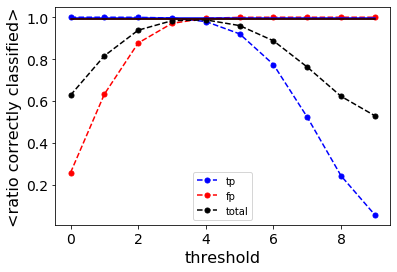

In [11]:
h = [None]*3

h[0], = plt.plot(thresh_list,mean_rat_tp_correct_thresh,'.--b',markersize=10)
h[1], = plt.plot(thresh_list,mean_rat_fp_correct_thresh,'.--r',markersize=10)
h[2], = plt.plot(thresh_list,mean_rat_correct_thresh,'.--k',markersize=10)
plt.plot(thresh_list,np.ones(Nt)*mean_rat_tp_correct,'b')
plt.plot(thresh_list,np.ones(Nt)*mean_rat_fp_correct,'r')
plt.plot(thresh_list,np.ones(Nt)*mean_rat_correct,'k')

#plt.fill_between(thresh_list, mean_rat_tp_correct_thresh - sem_rat_tp_correct_thresh, mean_rat_tp_correct_thresh + sem_rat_tp_correct_thresh, color='blue', alpha=0.2)
#plt.fill_between(thresh_list, mean_rat_fp_correct_thresh - sem_rat_fp_correct_thresh, mean_rat_fp_correct_thresh + sem_rat_fp_correct_thresh, color='red', alpha=0.2)
#plt.fill_between(thresh_list, mean_rat_correct_thresh - sem_rat_correct_thresh, mean_rat_correct_thresh + sem_rat_correct_thresh, color='black', alpha=0.2)
# when sem is small - no need to display it

plt.xlabel('threshold',fontsize=16)
plt.ylabel('<ratio correctly classified>',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
plt.legend(h, ('tp','fp','total'));